## Overview

In this notebook, the data of about 40,000 ICU patients are loaded into a data frame. 8 columns are dedicated to vital signs, 26 to laboratory results, and 9 to demographic data. The meanings of each column from the raw data are [given here](https://physionet.org/content/challenge-2019/1.0.0/).

__Additions__: 2 demographic columns are added to the original data set, which are:

    -'id': integer specifying unique patient id for each time point related to that patient
    -'HospitalA': 1 or 0 if patient was at Hopsital A or B, respectively

__Changes__: 

The following columns had some outliers & incorrect values changed to NaNs: 'FiO2','Temp', 'DBP', 'SBP', 'MAP'
    
The following lab value columns had outliers truncated (replaced with a more common value): BaseExcess, HCO3, pH, SaO2, lkalinephos, Calcium, Chloride, Creatinine, Bilirubin_direct, Potassium, Bilirubin_total, TroponinI, Hct, Hgb, BC, Fibrinogen, Platelets
    
Filled nans with 0s in Unit1 & Unit2 columns.

__Results__: Interim data is saved in the /data/interim folder of this project as 'sepsis_data_cleaned.csv'. A copy of the Pandas Profiling Report is saved in the /notebooks folder. 

## Discussion

Given that the data came from a well organized competion, all the data needed to build a sepsis predicition model is available. Sepsis Label is the target value.

6/8 of the vital fields have values for almost all patients, and they will most certainly be key in assessing the patient's state. 10 laboratory field values are available for at least 80% of patients. Some fields have no data for many of the patients, but this is not surprising as not all substances would be checked for in the blood by default - some are only asked for by the clinician if they suspect the patient is suffering from a particular problem, such as TroponinI in patients who are suspected to have had/soon have a heart attack. The lack of laboratory values in some patients may actually be helpful in accurately classifying sepsis.

I interviewed a former SICU nurse of 25+ years for insight into how physiological data is used in the SICU. She said that one data point doesn't matter all that much to clinicians- its the trend overtime, as well as the culmination of data points that they act on. Furthermore, a living patient can have a data point that one would think couldn't support human life - e.g. an O2sat of 50% in a COVID patient - because their body has had time to adapt to the condition. So, just because a data point is very extreme doesn't necessarily mean it's an error.

There are two important distinctions between the laboratory values and the vital signs that will influence how the data is cleaned. Firstly, laboratory values are collected in controlled lab environments with assumably reliable equipment. Secondly, in some patients, values are possible that are a vastly different scale that the average value, likely due to the presence of disease. For example, the median value of Alkalinephos in the data set is 75 IU/L, which is in line with a range of 20 to 140 IU/L for healthy patients.  But the patient having a maxmimum value of 2121.0 is plausble, as I found a paper that reported up to 3,360: [Source Here](https://pubmed.ncbi.nlm.nih.gov/9855266/). Nonetheless, if a lab value is an outlier, having a value 10x greather than the median will probably not be useful to the model- it would be enough to say the value is in a higher percentile. So some outliers, at a far out percetile, are replaced with a more medial percentile value.

In contrast, vital signs are collected via sensors placed on/in the patient. The sensors could loose contact with the patient overtime. Furthermore, there are some values that are known not compatible with human life - a heart rate of 1 or 1000, a temperature of 10 or 50 degrees celsius. It should also be considered that the accuracy of a sensor can diminish when the biological signal moves out of a typical range; for example, pulse oximeters perform well when O2 Sat values are  within the 90-100% range, but their accuracy drops off at lower values.


__Vital Signs__
Heart Rate and EtCO2 ranges completely plausible. Temperature had a few extreme values above 45 and below 30 that were marked as NaN.
Respiration and O2 Sats have low values seem suspect, but they are left as is for now. 
There are 3, related fields for blood pressure - DBP, SBP, MAP. In instances where DBP was greater than or equal to SBP, all BP values were marked as NaN. MAP is related to DBP & SBP with a simple arithmetic relation at low HR values, but can change at higher values. I did not make any changes if calculated MAP did not reasonably line up with DBP & SBP values, but they are suspect.


__Labratory Values__
Though I haven't checked every laboratory value range, they generally seem plausible - e.g. here glucose ranges from 14 to 988 mg/dl, and apparently the greatest ever recorded blood glucose level was 2656 mg/dl: [Source Here](https://www.guinnessworldrecords.com/world-records/highest-blood-sugar-level/?fb_comment_id=811257658947726_974655159274641#:~:text=Michael%20Patrick%20Buonocore%20(USA)%20(,%2D120%20mg%2Fdl).). 

__Demographic Data__
All check out except for HospAdmTime. Some extreme outliers here that don't make sense- 5000 hours between hospital admit and ICU admit is about 1/2 of a year. 

__Missingness__
Hospital B seems is missing a lot more laboratory values than Hospital A.

## Code Navigation
* [1. Import Libraries](#1.ImportLibraries)
* [2. Data Collection](#2.DataCollection)
* [3. Data Definition ](#3.DataDefinition)
    * [3.a General Data Characterization](#3.a.GeneralDataCharacterization)
    * [3.b Distributions - Raw](#3.b.Distributions-Raw)
    * [3.c Characterizing Missingness](#3.c.CharacterizingMissingness) 
* [4. Data Cleaning](#4.DataCleaning)
    * [4.a Exploring Vital Signs](#4.a.ExploringVitalSigns)
    * [4.b Exploring Lab Values](#4.b.ExploringLabValues)
    * [4.c Exploirng Demographic Info](#4.c.ExploringDemographicInfo)
    * [4.d Distributions - Modified](#4.d.Distributions-Modified)
* [5. Data Export](#5.DataExport)

## 1. Import Libraries <a class="anchor" id="1.ImportLibraries"></a>

In [1]:
import glob, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import operator
import seaborn as sns
#from pandas_profiling import ProfileReport
from collections import defaultdict

## 2. Data Collection<a class="anchor" id="2.DataCollection"></a>

In [2]:
os.chdir("../data")

In [3]:
#Code Adapted From
#https://www.kite.com/python/answers/how-to-make-a-single-pandas-dataframe-from-multiple-%60.csv%60-files-in-python
#Accessed February 17th, 2021

#Load data set A into a dataframe
#Add patient number column

i=0
id=[]
df_listA=[]
for file in glob.glob("training_setA/training/*.psv"):
    id.append(i)
    df_=pd.read_csv(file,sep='|')
    df_['id']=id[i]
    df_['HospitalA']=1
    df_listA.append(df_)
    i=i+1
rawA=pd.concat(df_listA).reset_index(drop=True)
rawA.shape

(790215, 43)

In [4]:
#Load data set B into a df, concatenate with previous df
#Continue patient numbering scheme

df_listB=[]
for file in glob.glob("training_setB/training_setB/*.psv"):
    id.append(i)   
    
    df_=pd.read_csv(file,sep='|')
    df_['id']=id[i]
    df_['HospitalA']=0
    df_listB.append(df_)
    i=i+1
rawB=pd.concat(df_listB)
raw=pd.concat([rawA,rawB]).reset_index(drop=True)
raw_copy=raw.copy()
raw.shape

(1552210, 43)

In [5]:
raw=raw_copy.copy()

## 3. Data Definition<a class="anchor" id="3.DataDefinition"></a>

### 3.a General Data Characterization<a class="anchor" id="3.a.GeneralDataCharacterization"></a>

In [ ]:
#Write Pandas Profiling Report
#profile = ProfileReport(raw, title="Raw Data Profile")
#os.chdir('../..')
#os.chdir('notebooks')
#profile.to_file("PandasProfilingReport.html")

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552210 entries, 0 to 1552209
Data columns (total 43 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   HR                1398811 non-null  float64
 1   O2Sat             1349474 non-null  float64
 2   Temp              525226 non-null   float64
 3   SBP               1325945 non-null  float64
 4   MAP               1358940 non-null  float64
 5   DBP               1065656 non-null  float64
 6   Resp              1313875 non-null  float64
 7   EtCO2             57636 non-null    float64
 8   BaseExcess        84145 non-null    float64
 9   HCO3              65028 non-null    float64
 10  FiO2              129365 non-null   float64
 11  pH                107573 non-null   float64
 12  PaCO2             86301 non-null    float64
 13  SaO2              53561 non-null    float64
 14  AST               25183 non-null    float64
 15  BUN               106568 non-null   float64
 16  

Most data types are what you'd expect - floats for physiological data, int64 for most demographic data. The Unit1 and Unit2 columns should be int because values are coded as 0 or 1; however, there are a lot of NaNs, so must leave as is.

In [7]:
#Summary statistics for numerical features
raw.describe().drop(labels=['HospitalA','id'],axis=1).T

,count,mean,std,min,25%,50%,75%,max
HR,1398811.0,84.581443,17.325242,20.00,72.00,83.500,95.50,280.00
O2Sat,1349474.0,97.193955,2.936924,20.00,96.00,98.000,99.50,100.00
Temp,525226.0,36.977228,0.770014,20.90,36.50,37.000,37.50,50.00
SBP,1325945.0,123.750465,23.231556,20.00,107.00,121.000,138.00,300.00
MAP,1358940.0,82.400100,16.341750,20.00,71.00,80.000,92.00,300.00
DBP,1065656.0,63.830556,13.956010,20.00,54.00,62.000,72.00,300.00
Resp,1313875.0,18.726498,5.098194,1.00,15.00,18.000,21.50,100.00
EtCO2,57636.0,32.957657,7.951662,10.00,28.00,33.000,38.00,100.00
BaseExcess,84145.0,-0.689919,4.294297,-32.00,-3.00,0.000,1.00,100.00
HCO3,65028.0,24.075481,4.376504,0.00,22.00,24.000,26.80,55.00


### 3.b Distributions - Raw <a class="anchor" id="3.b.Distributions-Raw"></a>

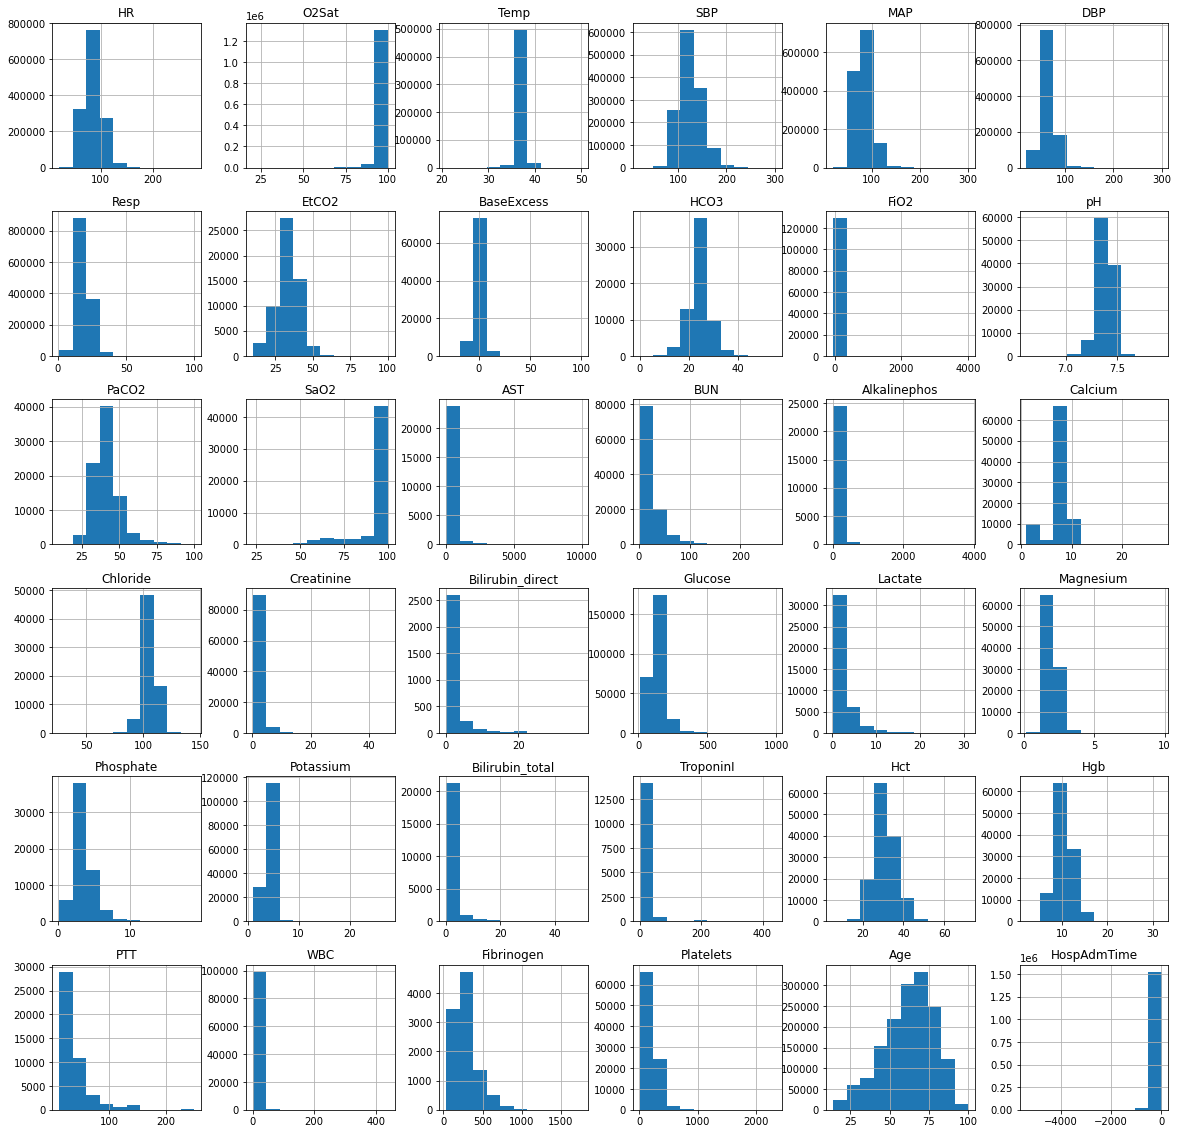

In [8]:
#Distributions for numerical features
raw.drop(labels=['Unit1','Unit2','Gender','SepsisLabel','id','HospitalA','ICULOS'],axis=1).hist(figsize=(20,20))
plt.show()

### 3.c Characterizing Missingness <a class="anchor" id="3.c.CharacterizingMissingness"></a>

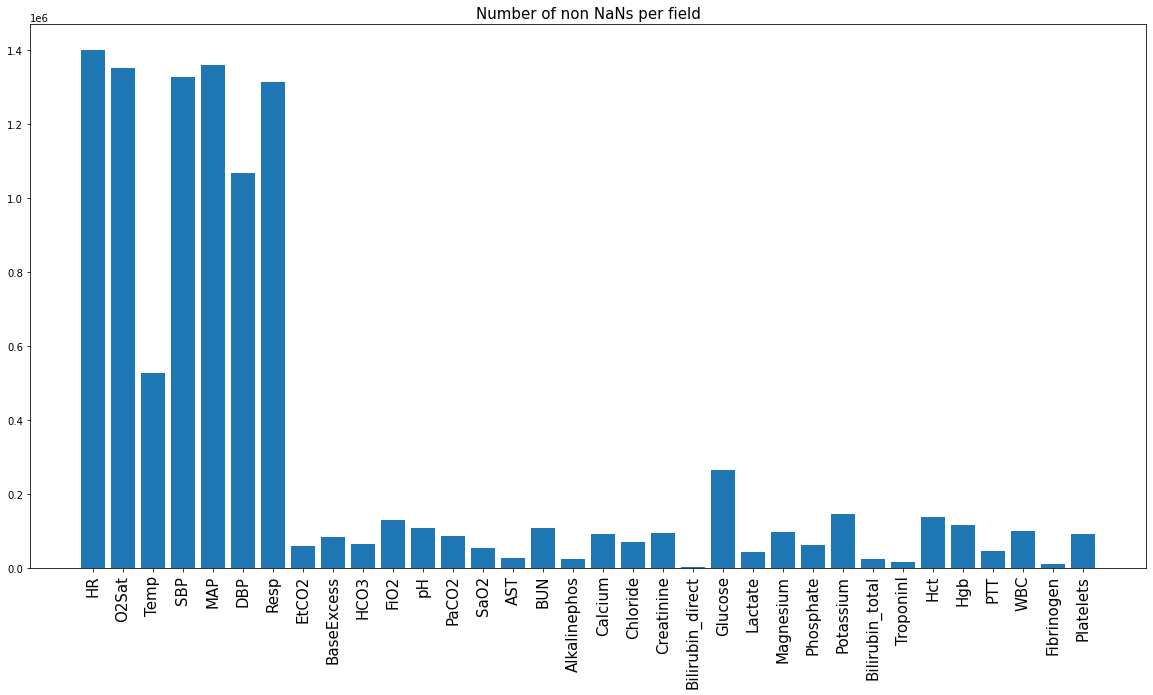

In [15]:
#Plot the Number of NaNs per field for all fields, across all patient entries
#Remove demographic columns
raw_b=raw.drop(labels=['Age','Gender','SepsisLabel','ICULOS','HospAdmTime','id','HospitalA','Unit1','Unit2'],axis=1)
labels=raw_b.columns.tolist()
#Calculate na sums, remove demographic columns
a=[raw_b[col].notna().sum() for col in labels]

plt.bar(labels,a)
plt.rcParams['figure.figsize'] = (20,10)
plt.xticks(labels,fontsize=15,rotation=90)
plt.title('Number of non NaNs per field',fontsize=15)
plt.show()

This plot indicates there are many NaNs in the laboratory fields. However, this is not surprising - since their is patient data hourly, you wouldn't expect lab data every hour. What would be more insightful is to know per patient, is there at least one laboratory value available. 

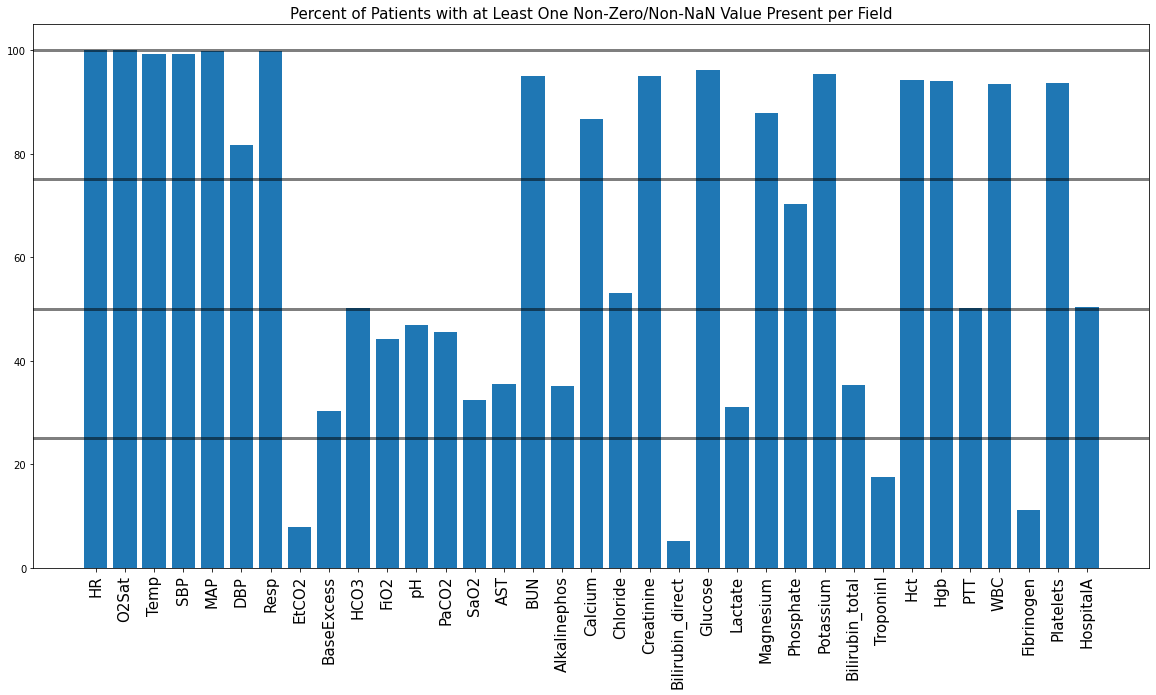

In [10]:
#For each field, plot the percentage of patients with at least one non-zero/NaN value present
n=raw['id'].nunique()
#Remove demographic columns
missing_by_id=raw.groupby(['id']).sum().drop(labels=['Age','Gender','SepsisLabel','ICULOS','HospAdmTime','Unit1','Unit2'],axis=1)
labels_=missing_by_id.columns.tolist()
d=defaultdict(int)
d_={}
for i in labels_:
    for j in range(0,n):
        if missing_by_id.loc[j,i]==0:
            d[i]+=1
    d_[i]=(1-d[i]/n)*100
    
plt.bar(d_.keys(),d_.values())
plt.rcParams['figure.figsize'] = (20,10)
plt.xticks(labels_,fontsize=15,rotation=90)
plt.axhline(25,c='black',lw=3,alpha=0.5)
plt.axhline(50,c='black',lw=3,alpha=0.5)
plt.axhline(75,c='black',lw=3,alpha=0.5)
plt.axhline(100,c='black',lw=3,alpha=0.5)
plt.title('Percent of Patients with at Least One Non-Zero/Non-NaN Value Present per Field',fontsize=15)
plt.show()

This plot shows that many lab values are not present in a majority of patients - not surprising because you would not expect each compund to be tested for everytime. But the missing values are good to keep in mind. Next I want to check the missingness by hospital.

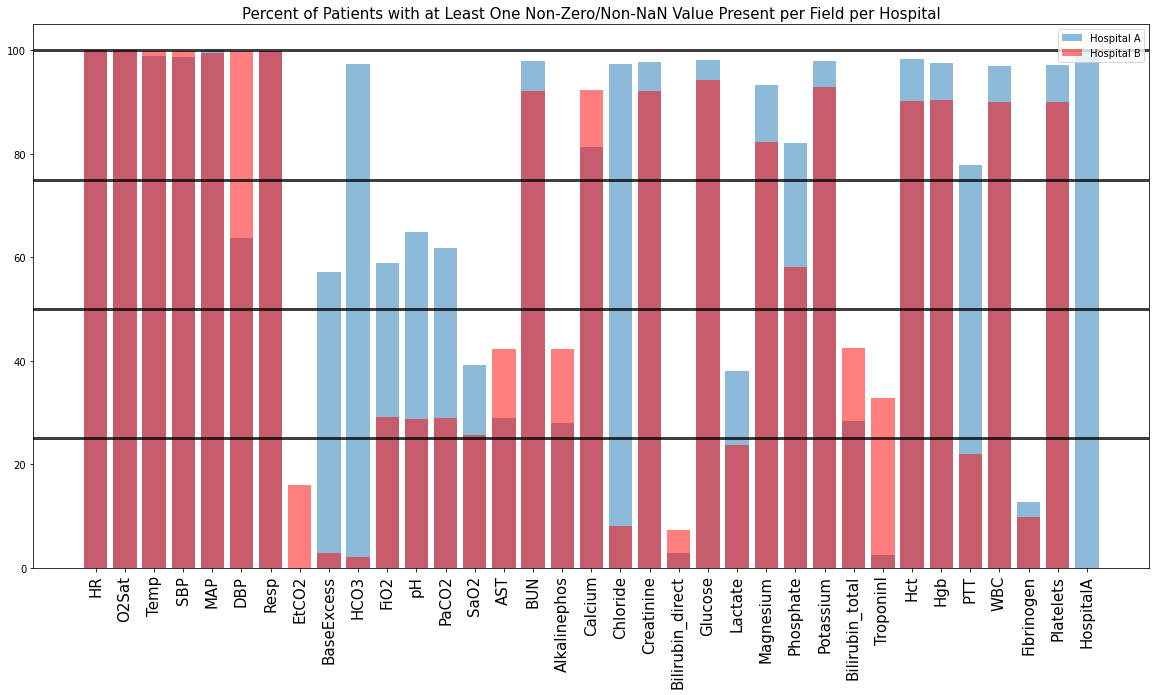

In [11]:
#For each field and hospital, plot the percentage of patients with at least one non-zero/NaN value present
missing_by_id_A=missing_by_id[missing_by_id.HospitalA>0].copy()
nA=len(missing_by_id_A.index)
labels_=missing_by_id_A.columns.tolist()

d=defaultdict(int)
d_={}
for i in labels_:
    for j in range(0,nA):
        if missing_by_id_A.loc[j,i]==0:
            d[i]+=1
    d_[i]=(1-d[i]/nA)*100
plt.bar(d_.keys(),d_.values(),alpha=0.5,label='Hospital A')
plt.rcParams['figure.figsize'] = (20,10)
plt.xticks(labels_,fontsize=15,rotation=90)
plt.axhline(25,c='black',lw=3,alpha=0.5)
plt.axhline(50,c='black',lw=3,alpha=0.5)
plt.axhline(75,c='black',lw=3,alpha=0.5)
plt.axhline(100,c='black',lw=3,alpha=0.5)
plt.title('Percent of patients with at least one value present per field at Hospital A',fontsize=15)

missing_by_id_B=missing_by_id[missing_by_id.HospitalA==0].copy()
nA=len(missing_by_id_A.index)
nB=len(missing_by_id_B.index)
d=defaultdict(int)
d_={}
for i in labels_:
    for j in range(nA,nB+nA):
        if missing_by_id_B.loc[j,i]==0:
            d[i]+=1
    d_[i]=(1-d[i]/nB)*100
plt.bar(d_.keys(),d_.values(),alpha=0.5,label='Hospital B',color='red')
plt.rcParams['figure.figsize'] = (20,10)
plt.xticks(labels_,fontsize=15,rotation=90)
plt.axhline(25,c='black',lw=3,alpha=0.5)
plt.axhline(50,c='black',lw=3,alpha=0.5)
plt.axhline(75,c='black',lw=3,alpha=0.5)
plt.axhline(100,c='black',lw=3,alpha=0.5)
plt.title('Percent of Patients with at Least One Non-Zero/Non-NaN Value Present per Field per Hospital',fontsize=15)
plt.legend(loc='upper right')
plt.show()

Hospital B is missing far more lab values than Hospital A; Hospital A is responsible for all missing values in the DBP vital column. Something to keep in mind for later.

### 4.a Exploring Vital Signs<a class="anchor" id="4.a.ExploringVitalSigns"></a>

In [12]:
#Get 10 highest temperature values & their patient id
raw[['Temp','id']].sort_values(by='Temp',ascending=False)[0:10]

,Temp,id
1163645,50.00,30201
1141918,50.00,29603
585219,42.22,15103
904175,42.10,23345
904176,42.00,23345
585218,41.97,15103
585220,41.92,15103
904177,41.80,23345
1365391,41.80,35438
585224,41.71,15103


In [13]:
#The human body cannot possible reach temperatures of 50 degrees celsius - so the 50 degree value is not plausible.
#The second highest is 42.22C, which is plausible
raw.loc[raw['Temp']>45,'Temp']=np.nan

In [14]:
##Get 15 lowest temperature values & their patient id
raw[['Temp','id']].sort_values(by='Temp')[0:15]

,Temp,id
94334,20.90,2420
295697,21.00,7619
753515,23.00,19394
14218,23.60,371
262502,26.60,6768
105926,26.67,2719
334656,26.67,8631
743116,26.67,19135
96868,26.67,2477
263574,26.67,6796


A patient would need to be hypothermic to have temperatures below 31 degrees celsius - a clinician would not purposefully set a patient's body temperature below 88 degrees, according to SICU contact. Below I'll plot the time course for patients with at least one temperature value below 31 - if they seem to be outliers within a patient's own range, will mark those values as NaNs for the patient. 

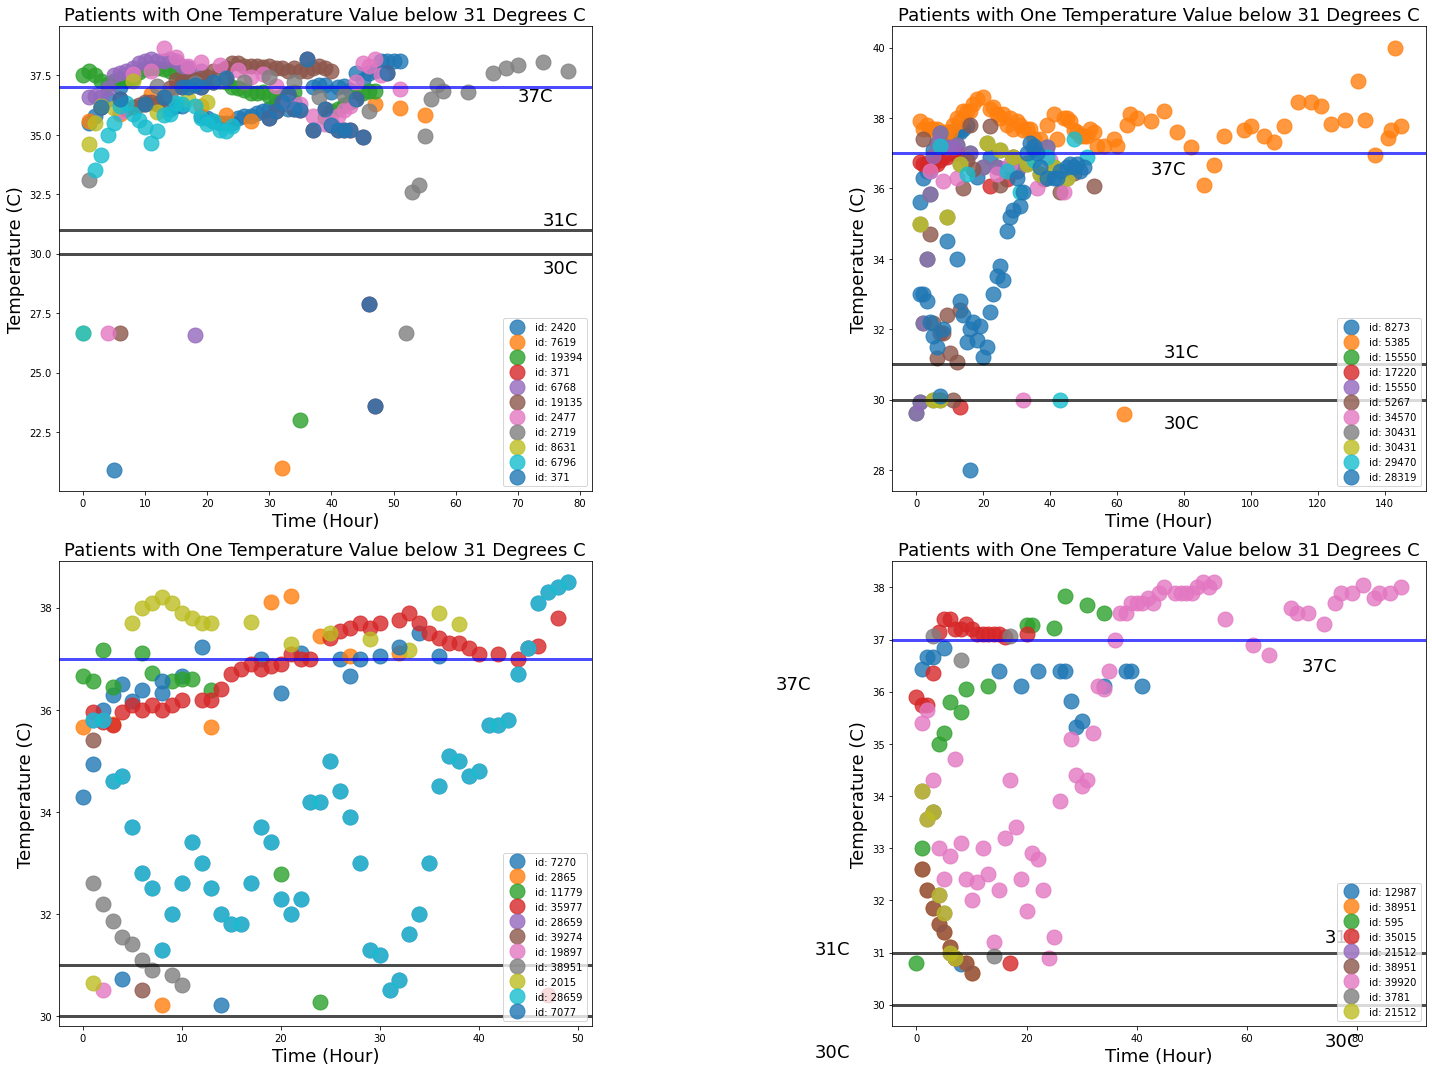

In [16]:
#Plot 4 seperate graphs to better illustrate all patients
Low_Temp=raw[['Temp','id']].loc[raw.Temp<=31].sort_values(by='Temp')
Low_Temp_id=Low_Temp['id'].values

k=0
g=2
plt.subplots(figsize=(20,15))
plt.subplot(2,2,1)
for i in Low_Temp_id:
    y_=raw[['Temp','id']].loc[raw.id==i]
    y=y_['Temp'].reset_index(drop=True)
    plt.plot(y,marker='.',linestyle='none',markersize=30,alpha=0.8,label='id: '+ str(i))
    k=k+1
    if k==11:
        plt.axhline(31,c='black',lw=3,alpha=0.7)
        plt.text(74,31.2,'31C',size=18)
        plt.axhline(30,c='black',lw=3,alpha=0.7)
        plt.text(74,29.2,'30C',size=18)
        plt.axhline(37,c='blue',lw=3,alpha=0.7)
        plt.text(70,36.4,'37C',size=18)
        plt.xlabel('Time (Hour)',size=18)
        plt.ylabel('Temperature (C)',size=18)
        plt.title('Patients with One Temperature Value below 31 Degrees C',size=18)
        plt.legend(loc='lower right')
        plt.subplot(2,2,g)
        g=g+1
        k=0
plt.axhline(31,c='black',lw=3,alpha=0.7)
plt.text(74,31.2,'31C',size=18)
plt.axhline(30,c='black',lw=3,alpha=0.7)
plt.text(74,29.2,'30C',size=18)
plt.axhline(37,c='blue',lw=3,alpha=0.7)
plt.text(70,36.4,'37C',size=18)
plt.xlabel('Time (Hour)',size=18)
plt.ylabel('Temperature (C)',size=18)
plt.title('Patients with One Temperature Value below 31 Degrees C',size=18)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [17]:
#There is a cluster of points between 30 and 31 degrees for some patients in their initial hours - maybe they were 
#hypothermic when they got to the hopsital. Below 30 degrees, the points get quite random. Will mark only the values 
#less than 30 as NaN. 
raw.loc[raw['Temp']<30,'Temp']=np.nan

In [18]:
#Get 20 highest respiration values & their patient id
raw[['Resp','id']].sort_values(by='Resp',ascending=False)[0:20]
#I would think 100 breaths/minute would not be possible, but these values are not exactly out on their own. 
#Will leave as is. 

,Resp,id
1036254,100.0,26823
1184351,100.0,30738
1132037,100.0,29344
838132,100.0,21577
954477,100.0,24693
1128421,99.0,29251
1115408,99.0,28912
1543636,99.0,40126
1085357,99.0,28104
1369213,99.0,35542


In [19]:
#Get 1000 lowest respiration values & their patient id
raw[['Resp','id']].sort_values(by='Resp')[0:1000]
#Again, I would think 1 breaths/minute would not be possible, but these values are not exactly out on their own. 
#Will leave as is. 

,Resp,id
1288525,1.0,33423
1252181,1.0,32484
1250945,1.0,32451
877750,1.0,22645
878369,1.0,22661
...,...,...
939557,2.0,24301
939556,2.0,24301
822403,2.0,21168
816343,2.0,21012


In [20]:
#O2Sat field - Oxygen Saturation %
#Get 20 lowest O2Sat values & their patient id
raw[['O2Sat','id']].sort_values(['O2Sat'])[0:500]
#This is a long tailed distribution (to the left). O2 sat values less than 50 should not be compatible with life. 
#These lower values may be indicative of poor pulse oximeter performance; they are known to
#perform extremely well when O2 Sat values are high, worse when they are lower. 

,O2Sat,id
1096010,20.0,28385
1505168,20.0,39124
993316,20.0,25707
1060427,20.0,27456
1475332,20.0,38356
...,...,...
494318,59.0,12745
272691,59.0,7039
1204539,59.0,31258
1287389,59.0,33391


Below I'll plot the time course for patients with at least one O2Sat value below 25% to further investigate.

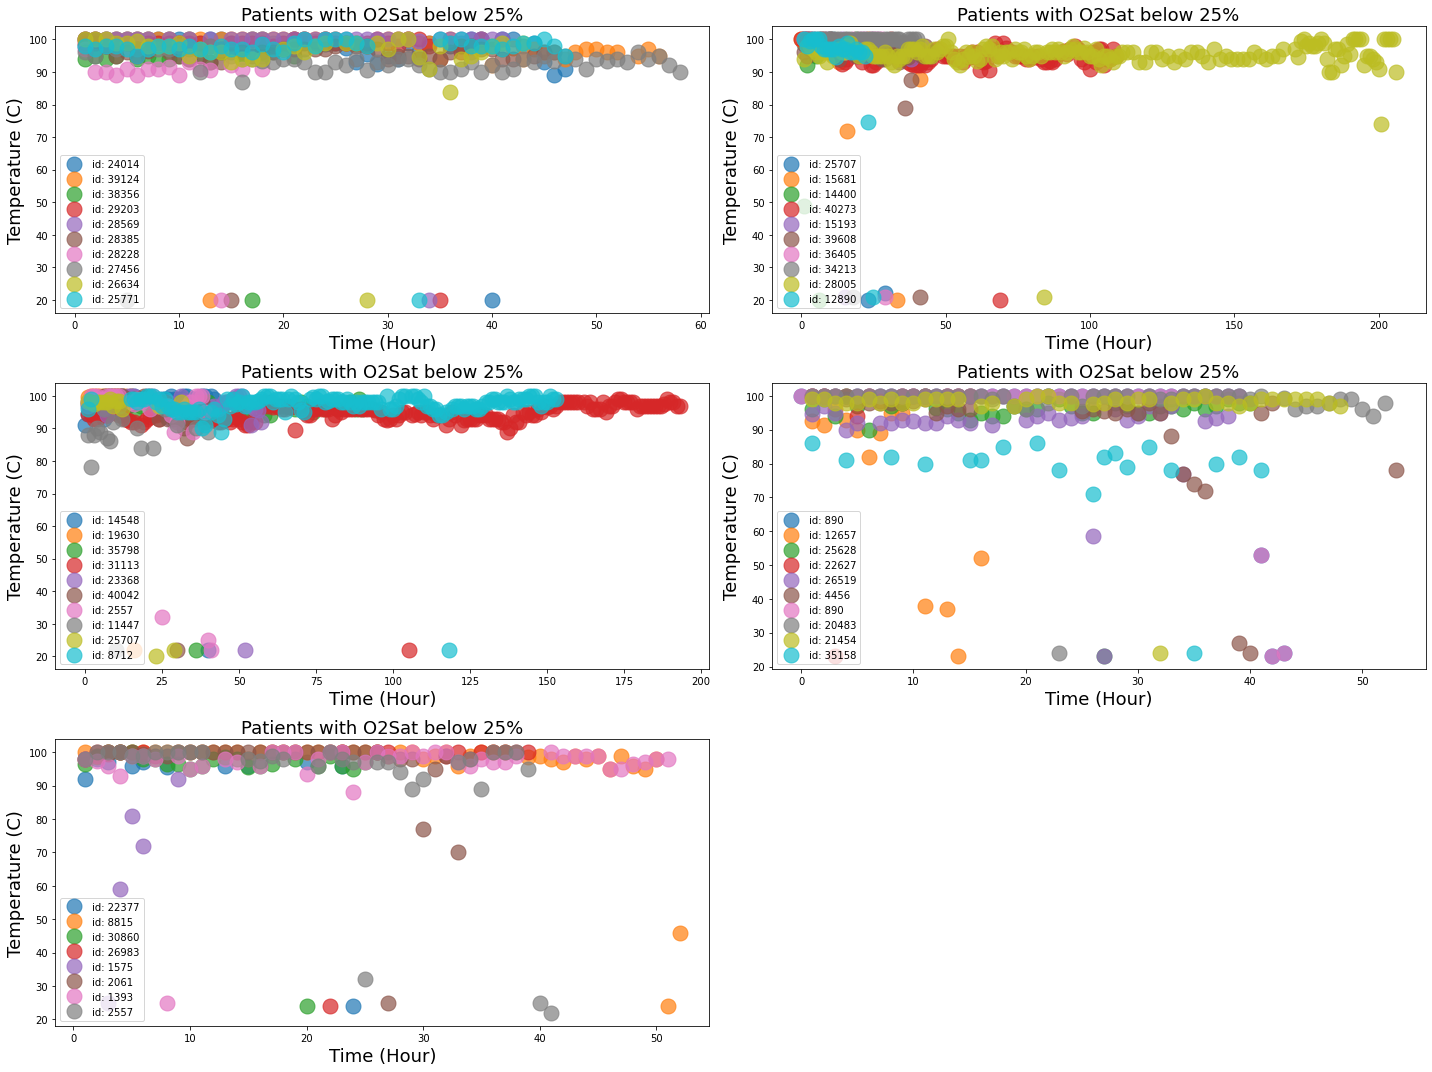

In [21]:
Low_O2Sat=raw[['O2Sat','id']].loc[raw.O2Sat<=25].sort_values(by='O2Sat')
Low_O2Sat_id=Low_O2Sat['id'].values

k=0
g=2
plt.subplots(figsize=(20,15))
plt.subplot(3,2,1)
for i in Low_O2Sat_id:
    y_=raw[['O2Sat','id']].loc[raw.id==i]
    y=y_['O2Sat'].reset_index(drop=True)
    plt.plot(y,marker='.',linestyle='none',markersize=30,alpha=0.7,label='id: '+ str(i))
    k=k+1
    if k==10:
        plt.xlabel('Time (Hour)',size=18)
        plt.ylabel('Temperature (C)',size=18)
        plt.title('Patients with O2Sat below 25%',size=18)
        plt.legend(loc='lower left')
        plt.subplot(3,2,g)
        g=g+1
        k=0
plt.xlabel('Time (Hour)',size=18)
plt.ylabel('Temperature (C)',size=18)
plt.title('Patients with O2Sat below 25%',size=18)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

Most of these patients are obviously quite sick (e.g. 890, 2557, 5248) but someone like 1393 could just have an outlying, incorrect reading? Hard to tell. Will leave as is.

In [22]:
#DBP values cannot be greater than or equal to SBP. Let's see if any are.
r=(raw[['DBP','SBP','MAP']].loc[raw.DBP.values>=raw.SBP.values])
r

,DBP,SBP,MAP
2384,287.0,97.0,77.67
6555,130.0,127.0,58.00
10404,115.5,112.5,75.00
16125,166.5,164.0,68.33
47110,80.0,74.0,33.00
...,...,...,...
1527873,237.0,237.0,237.00
1535125,177.0,177.0,177.00
1535648,129.5,123.5,112.00
1541360,102.0,66.0,148.00


In [23]:
#Instances where DBP>SBP will be changed to NaN. Confirm that no incorrect values remain.
raw.loc[r.index,['DBP','SBP','MAP']]=np.nan
raw[['DBP','SBP','MAP']].loc[raw.DBP.values>raw.SBP.values]

,DBP,SBP,MAP


In [24]:
#Now Let's explore blood pressure values and patient id, sorted by each type of BP. First up, Mean Arterial Pressure.
raw[['DBP','SBP','MAP','id']].sort_values(by='MAP',ascending=False)[0:10]

,DBP,SBP,MAP,id
334369,42.0,143.0,300.0,8622
1312195,291.0,NaN,300.0,34039
1391802,68.0,109.0,300.0,36158
1451734,68.0,141.0,300.0,37736
334370,39.0,152.0,300.0,8622
980885,62.0,140.0,298.0,25387
980884,65.0,123.0,298.0,25387
215118,82.0,108.0,298.0,5532
1325366,79.0,99.0,298.0,34379
464564,66.0,117.0,298.0,11976


In [25]:
#Next up is Diastolic
raw[['DBP','SBP','MAP']].sort_values(by='DBP',ascending=False)[0:10]
#Diastolic cannot possibly be larger than systolic. Something wrong here. 

,DBP,SBP,MAP
1108265,300.0,NaN,NaN
837702,293.0,294.0,293.0
1312195,291.0,NaN,300.0
845582,285.0,299.0,292.0
995937,284.0,293.0,286.0
1451906,281.0,282.0,281.0
1313827,280.0,292.0,282.0
842891,280.0,NaN,283.0
1123919,278.0,295.0,181.0
1241896,274.0,280.0,278.0


In [26]:
#Finally, Systolic
raw[['DBP','SBP','MAP']].sort_values(by='SBP',ascending=False)[0:10]

,DBP,SBP,MAP
845582,285.0,299.0,292.0
937022,88.0,296.0,144.0
1123919,278.0,295.0,181.0
837702,293.0,294.0,293.0
995937,284.0,293.0,286.0
1313827,280.0,292.0,282.0
1451906,281.0,282.0,281.0
223289,110.0,281.0,134.0
820605,272.0,281.0,275.0
1241896,274.0,280.0,278.0


These are all plausible ranges. Now I want to check if MAP values follow the standard calculation of MAP=(DBP*2+SBP)/3.

In [27]:
#Calculate MAP values, add new column called 'MAP_Calc'. Drop any rows without BP values.
raw_interim=raw.copy()
raw_interim=raw_interim[['id','DBP','SBP','MAP','HR']]
raw_interim['MAP_Calc']=(raw.SBP+raw.DBP*2)/3
raw_interim.dropna(how='any',axis=0,inplace=True)
raw_interim.reset_index(inplace=True)
raw_interim
 
#Determine which recorded MAP values are outside the range of MAP_Calc +/- 10. 
n=len(raw_interim)
q=np.empty(n)
for i in range(n):
    if (raw_interim.loc[raw_interim.index[i],'MAP']<raw_interim.loc[raw_interim.index[i],'MAP_Calc']+10) and (raw_interim.loc[raw_interim.index[i],'MAP']>raw_interim.loc[raw_interim.index[i],'MAP_Calc']-10):
        q[i]=True
    else:
        q[i]=False
a=np.unique(q,return_counts=True)
a

(array([0., 1.]), array([  46158, 1007156], dtype=int64))

4.5% of available MAP values are outside the MAP_Calc +/- 10 range. Won't move on this for now, something to revisit.

### 4.b Exploring Lab Values<a class="anchor" id="4.b.ExploringLabValues"></a>

In [28]:
#Base Excess Field
#Get 10 highest Base Excess values & their patient id
raw[['BaseExcess','id']].sort_values(by='BaseExcess',ascending=False)[0:10]

,BaseExcess,id
521043,100.0,13460
307038,49.5,7921
217566,44.0,5600
777226,36.0,19999
387526,28.0,9975
217567,26.0,5600
490896,26.0,12660
209736,26.0,5396
542462,25.0,14009
371166,25.0,9547


In [29]:
#Outliers. Replacing anything above 30 with 30. 
raw.loc[raw['BaseExcess']>30,'BaseExcess']=30

In [30]:
#HCO3 Field
#Get 100 highest  values & their patient id
raw[['HCO3','id']].sort_values(by='HCO3',ascending=False)[0:100]
#Leave as is

,HCO3,id
371152,55.0,9547
371165,55.0,9547
371139,53.0,9547
41671,52.0,1069
196761,50.0,5049
...,...,...
658856,43.0,17010
658875,43.0,17010
148456,43.0,3815
140060,43.0,3619


In [31]:
#HCO3 Field
#Get 100 lowest values & their patient id
raw[['HCO3','id']].sort_values(by='HCO3')[0:100]

,HCO3,id
206002,0.0,5307
610784,0.0,15770
352236,5.0,9077
549430,5.0,14195
379916,5.0,9772
...,...,...
411449,8.0,10610
299679,8.0,7721
348891,8.0,8992
87856,8.0,2251


In [32]:
#Replace HCO3 value below 5 with 5
raw['HCO3']=np.where((raw.HCO3<5),5,raw.HCO3)

In [33]:
#FiO2 field - Fraction of Inspired Oxygen
#Get 10 highest FiO2 values & their patient id
raw[['FiO2','id']].sort_values(by='FiO2',ascending=False)[0:10]

,FiO2,id
1059477,4000.00,27431
651403,10.00,16799
125992,7.00,3241
1195728,5.05,31036
1535409,2.00,39920
1273691,2.00,33031
983242,2.00,25451
1376155,2.00,35732
1099424,2.00,28474
837154,2.00,21550


In [34]:
#FiO2 values cannot possibly be greater than 1 (they are a fraction), 
#so these values greater than 1 will be changed to NaN 
raw.loc[raw['FiO2']>1,'FiO2']=np.nan

In [35]:
#FiO2 field - Fraction of Inspired Oxygen
#Get 10 lowest FiO2 values & their patient id
raw[['FiO2','id']].sort_values(by='FiO2',ascending=True)[0:10]

,FiO2,id
1243150,-50.0,32257
983542,-50.0,25457
752302,0.0,19364
435928,0.0,11240
290117,0.0,7480
579391,0.0,14957
425326,0.0,10975
397891,0.0,10254
294669,0.0,7592
640947,0.0,16543


In [36]:
#FiO2 values cannot possibly be less than 0 (they are a fraction), 
#so these 2 values greater than 1 will be changed to NaN 
raw.loc[raw['FiO2']<0,'FiO2']=np.nan

In [37]:
#pH Field
#Get 100 highest values & their patient id
raw[['pH','id']].sort_values(by='pH',ascending=False)[0:100]

,pH,id
703683,7.93,18166
490896,7.80,12660
217566,7.78,5600
50427,7.73,1297
711314,7.72,18358
...,...,...
1210084,7.61,31403
551913,7.61,14258
351765,7.61,9064
932249,7.61,24101


In [38]:
#Replace pH value above 7.8 with 7.8
raw['pH']=np.where((raw.pH>7.8),7.8,raw.pH)

In [39]:
#pH Field
#Get 100 lowest values & their patient id
raw[['pH','id']].sort_values(by='pH')[0:100]

,pH,id
82166,6.62,2103
496562,6.63,12812
188318,6.65,4834
1468480,6.71,38174
834457,6.72,21476
...,...,...
1212853,6.96,31474
7411,6.96,195
1316864,6.97,34153
1464065,6.97,38056


In [40]:
#Replace pH value below 6.8 with 6.8
raw['pH']=np.where((raw.pH<6.8),6.8,raw.pH)

In [41]:
#PaCO2 Field
#Get 100 highest PaCO2 values & their patient id
raw[['PaCO2','id']].sort_values(by='PaCO2',ascending=False)[0:100]
#No outright outliers, leaving as is.

,PaCO2,id
3,100.0,0
396699,100.0,10219
383687,100.0,9872
1233403,100.0,31999
119074,100.0,3064
...,...,...
61091,94.0,1567
1014844,94.0,26259
61087,94.0,1567
396711,94.0,10219


In [42]:
#SaO2 Field
#Get 100 lowest values & their patient id
raw[['SaO2','id']].sort_values(by='SaO2',ascending=True)[0:100]

,SaO2,id
1125856,23.0,29184
710926,24.0,18349
287117,26.0,7416
691268,27.0,17841
386976,27.0,9962
...,...,...
607414,43.0,15674
321719,44.0,8298
425988,44.0,10991
222683,44.0,5732


In [43]:
#Replace SaO2 value below 30 with 30
raw['SaO2']=np.where((raw.SaO2<30),30,raw.SaO2)

In [44]:
#AST field
#Get 500 highest AST values & their patient id
raw[['AST','id']].sort_values(by='AST',ascending=False)[0:500]
#Though this is quite a long tailed distribution, these outliers are not by themselves. Will leave as is. 

,AST,id
831061,9961.0,21388
240769,9890.0,6209
582716,9840.0,15035
582717,9840.0,15035
1391475,9747.0,36150
...,...,...
730429,3058.0,18822
101316,3054.0,2599
1187774,3053.0,30824
1321175,3047.0,34264


In [45]:
#BUN field
#Get 500 highest BUN values & their patient id
raw[['BUN','id']].sort_values(by='BUN',ascending=False)[0:500]
#Though this is quite a long tailed distribution, these outliers are not by themselves. Will leave as is.

,BUN,id
943529,268.0,24399
249420,266.0,6432
1027365,252.0,26596
190106,235.0,4883
190112,234.0,4883
...,...,...
1541886,119.0,40084
1419586,119.0,36882
1150043,119.0,29824
849823,119.0,21892


In [46]:
#Alkalinephos field
#Get 100 highest Alkalinephos values & their patient id
raw[['Alkalinephos','id']].sort_values(by='Alkalinephos',ascending=False)[0:100]

,Alkalinephos,id
546930,3833.0,14121
546931,3833.0,14121
546960,3619.0,14121
546959,3619.0,14121
174385,2528.0,4491
...,...,...
584301,864.0,15077
763777,862.0,19657
936377,859.0,24214
62312,859.0,1598


In [47]:
#According to a publication (cited in intro), can have Alkalinephos as high as 3,000 U/l in patients with 
#certain diseases. These values go higher. Anything over 3000 will be replace with 3000
raw['Alkalinephos']=np.where((raw.Alkalinephos>3000),3000,raw.Alkalinephos)

In [48]:
#Calcium Field
#Get 100 highest Calcium values & their patient id
raw[['Calcium','id']].sort_values(by='Calcium',ascending=False)[0:100]

,Calcium,id
871222,27.9,22459
967911,27.0,25048
871202,27.0,22459
998297,25.2,25838
1027365,24.9,26596
...,...,...
1055074,17.8,27310
1002881,17.8,25954
1310347,17.8,33982
1484340,17.8,38592


In [49]:
#Replace calcium value above 21 with 21.
raw['Calcium']=np.where((raw.Calcium>21),21,raw.Calcium)

In [50]:
#Chloride Field
#Get 100 lowest Chloride values & their patient id
raw[['Chloride','id']].sort_values(by='Chloride')[0:100]

,Chloride,id
487398,26.0,12574
495028,38.0,12766
670438,63.0,17302
678264,66.0,17509
670435,66.0,17302
...,...,...
392802,83.0,10114
612950,83.0,15828
148464,83.0,3815
392765,83.0,10114


In [51]:
#Two big outliers! Will replace with next smallest
raw['Chloride']=np.where((raw.Chloride<60),63,raw.Chloride)

In [52]:
#Creatinine Field
#Get 100 highest Creatinine values & their patient id
raw[['Creatinine','id']].sort_values(by='Creatinine',ascending=False)[0:100]

,Creatinine,id
702035,46.60,18125
943529,41.90,24399
1145270,29.86,29696
1188019,29.20,30830
425769,29.10,10985
...,...,...
1110440,17.15,28772
1481695,17.12,38524
1052897,17.10,27252
1211000,17.10,31425


In [53]:
#Outliers. Replacing anything above 25 with 25. 
raw.loc[raw['Creatinine']>25,'Creatinine']=25

In [54]:
#Bilirubin Direct
#Get 100 highest Bilirubin Direct values & their patient id
raw[['Bilirubin_direct','id']].sort_values(by='Bilirubin_direct',ascending=False)[0:100]

,Bilirubin_direct,id
547223,37.5,14130
200104,35.0,5140
485921,30.0,12531
830198,30.0,21363
13597,29.1,356
...,...,...
511172,11.4,13207
511173,11.4,13207
658941,11.4,17012
919477,11.2,23764


In [55]:
#Outliers. Replacing anything above 30 with 30. 
raw.loc[raw['Bilirubin_direct']>30,'Bilirubin_direct']=30

In [56]:
#Glucose Field
#Get 100 highest Glucose values & their patient id
raw[['Glucose','id']].sort_values(by='Glucose',ascending=False)[0:100]
#Not on their own. Leaving as is. 

,Glucose,id
645018,988.0,16629
670438,960.0,17302
305024,952.0,7865
670435,942.0,17302
386728,934.0,9955
...,...,...
55056,651.0,1410
1341320,650.5,34790
670445,650.0,17302
669640,648.0,17280


In [57]:
#Lactate Field
#Get 100 highest  values & their patient id
raw[['Lactate','id']].sort_values(by='Lactate',ascending=False)[0:100]
#Not ont their own. Leaving as is. 

,Lactate,id
120277,31.00,3094
730514,28.90,18822
599583,28.80,15467
86043,27.00,2207
599596,26.90,15467
...,...,...
1241564,18.33,32217
831074,18.32,21388
33119,18.30,851
429012,18.30,11063


In [58]:
#Magnesium Field
#Get 100 highest  values & their patient id
raw[['Magnesium','id']].sort_values(by='Magnesium',ascending=False)[0:100]
#Not on their own. Leaving as is. 

,Magnesium,id
1074513,9.8,27821
247278,9.7,6376
653672,9.6,16863
1425578,9.3,37045
1074518,9.2,27821
...,...,...
796550,4.7,20497
44252,4.7,1139
81169,4.7,2080
81170,4.7,2080


In [59]:
#Phosphate Field
#Get 100 highest  values & their patient id
raw[['Phosphate','id']].sort_values(by='Phosphate',ascending=False)[0:100]
#Not on their own. Leaving as is.

,Phosphate,id
409603,18.8,10557
314670,17.6,8123
60757,16.9,1558
88606,16.5,2271
357549,16.4,9206
...,...,...
1217099,11.6,31579
1342889,11.6,34825
1342886,11.6,34825
1338452,11.5,34719


In [60]:
#Potassium Field
#Get 10 highest Potassium values & their patient id
raw[['Potassium','id']].sort_values(by='Potassium',ascending=False)[0:10]

,Potassium,id
96553,27.50,2469
1123017,15.80,29115
340985,13.00,8792
1493462,11.80,38834
1327655,11.50,34443
1280764,11.50,33215
795350,10.80,20469
879102,10.80,22683
943529,10.75,24399
1478125,10.60,38428


In [61]:
#One big outlier! Will replace with next largest value
raw['Potassium']=np.where((raw.Potassium>15),10.8,raw.Potassium)

In [62]:
#TroponinI Total Field
#Get 100 highest TroponinI values & their patient id
raw[['TroponinI','id']].sort_values(by='TroponinI',ascending=False)[0:100]

,TroponinI,id
1325964,440.00,34396
999674,440.00,25880
999691,440.00,25880
883448,394.03,22801
1343558,381.60,34844
...,...,...
1286632,180.63,33369
1083479,180.08,28052
1172377,180.08,30426
1106488,179.38,28659


In [63]:
#Replace everything above 300 with 300.
raw['TroponinI']=np.where((raw.TroponinI>300),300,raw.TroponinI)

In [64]:
#Hct Field
#Get 200 highest  values & their patient id
raw[['Hct','id']].sort_values(by='Hct',ascending=False)[0:200]
#Not on their own. Leaving as is.

,Hct,id
242185,71.7,6250
1469116,70.2,38192
242182,69.7,6250
242209,66.4,6250
242199,66.2,6250
...,...,...
1028981,50.5,26638
1432994,50.5,37245
925202,50.5,23920
443621,50.5,11434


In [65]:
#Hct Field
#Get 100 lowest  values & their patient id
raw[['Hct','id']].sort_values(by='Hct')[0:100]

,Hct,id
648103,5.5,16711
713166,7.0,18409
71486,8.8,1834
1528951,9.1,39759
942911,9.3,24385
...,...,...
274906,14.7,7097
1320819,14.8,34255
836487,14.8,21534
33028,14.9,849


In [66]:
#Outliers. Replacing anything below 10 with 10
raw.loc[raw['Hct']<10,'Hct']=10

In [67]:
#Hgb Field
#Get 100 highest values & their patient id
raw[['Hgb','id']].sort_values(by='Hgb',ascending=False)[0:100]

,Hgb,id
518054,32.0,13377
1475600,30.0,38362
1189476,26.6,30866
984178,25.0,25470
1120953,24.8,29058
...,...,...
1439378,18.5,37414
51749,18.5,1326
1136315,18.4,29446
1149081,18.4,29800


In [68]:
#Outliers. Replacing anything above 25 with 25
raw.loc[raw['Hgb']>25,'Hgb']=25

In [69]:
#Hgb Field
#Get 100 lowest values & their patient id
raw[['Hgb','id']].sort_values(by='Hgb')[0:100]
#Not on their own. Leave as is.

,Hgb,id
713166,2.2,18409
1483308,2.3,38567
942911,2.6,24385
1528951,2.8,39759
1499102,2.9,38970
...,...,...
1494009,4.8,38848
1292624,4.8,33526
836487,4.8,21534
1085480,4.8,28108


In [70]:
#PTT Field
#Get 100 highest values & their patient id
raw[['PTT','id']].sort_values(by='PTT',ascending=False)[0:100]
#Not on their own. Leave as is.

,PTT,id
1474974,250.0,38345
825687,250.0,21254
825693,250.0,21254
1418918,250.0,36864
815359,250.0,20991
...,...,...
1052120,249.0,27235
1320863,249.0,34256
957239,249.0,24764
957235,249.0,24764


In [71]:
#WBC Field
#Get 100 highest WBC values & their patient id
raw[['WBC','id']].sort_values(by='WBC',ascending=False)[0:100]

,WBC,id
875728,440.0,22589
579589,422.9,14963
1377489,387.0,35770
579592,375.4,14963
579591,342.0,14963
...,...,...
428987,83.4,11063
936731,82.6,24226
56228,81.9,1445
673333,81.6,17379


In [72]:
#Replace everything above 300 with 300.
raw['WBC']=np.where((raw.WBC>300),300,raw.WBC)

In [73]:
#Fibrinogen Field
#Get 100 highest values & their patient id
raw[['Fibrinogen','id']].sort_values(by='Fibrinogen',ascending=False)[0:100]

,Fibrinogen,id
197318,1760.0,5065
578048,1383.0,14923
511127,1246.0,13205
511126,1246.0,13205
944283,1179.0,24420
...,...,...
625618,828.0,16151
577063,827.0,14894
167198,822.0,4302
1401294,820.0,36403


In [74]:
#Replace everything above 1100 with 1100.
raw['Fibrinogen']=np.where((raw.Fibrinogen>1100),1100,raw.Fibrinogen)

In [75]:
#Platelets Field
#Get 100 highest  values & their patient id
raw[['Platelets','id']].sort_values(by='Platelets',ascending=False)[0:100]

,Platelets,id
937204,2322.0,24239
258522,1783.0,6664
188586,1667.0,4842
258494,1592.0,6664
188593,1421.0,4842
...,...,...
872321,838.0,22489
902812,836.0,23307
260527,836.0,6716
1023516,834.0,26496


In [76]:
#Replace everything above 1100 with 1100.
raw['Platelets']=np.where((raw.Platelets>1100),1100,raw.Platelets)

### 4.c Exploring Demographic Info<a class="anchor" id="4.c.ExploringDemographicInfo"></a>

In [77]:
#Verifying that Gender only has values of 1 or 0, and there are no NaNs. Looks good. 
G_vc=raw.Gender.value_counts()
G_vc[1]+G_vc[0]-len(raw)

0

In [78]:
#Verifying that Unit1 only has values of 1 or 0
raw.Unit1.value_counts()

0.0    473349
1.0    466901
Name: Unit1, dtype: int64

In [79]:
#Verifying that Unit1 only has values of 1 or 0
raw.Unit2.value_counts()

1.0    473349
0.0    466901
Name: Unit2, dtype: int64

Looks like Unit1 and Unit 2 info are missing for a lot of patients -  this is in line with the missingness bar plot above. So its not clear if some patients are or are not in a certain ICU or another unit altogether - something to keep in mind.

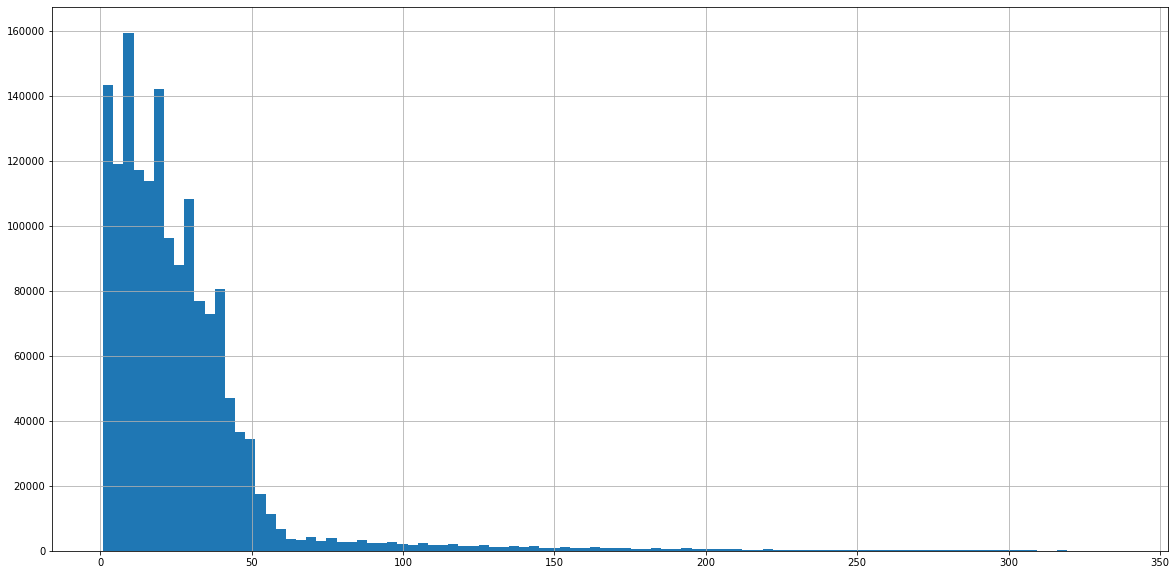

In [80]:
#Histogram of ICULOS field; represents ICU length-of-stay (hours since ICU admit) for all patients, every hour
#No wild outliers here, this field checks out - maximum ICU stay length is about 2 weeks. 
raw.ICULOS.hist(bins=100)
plt.show()

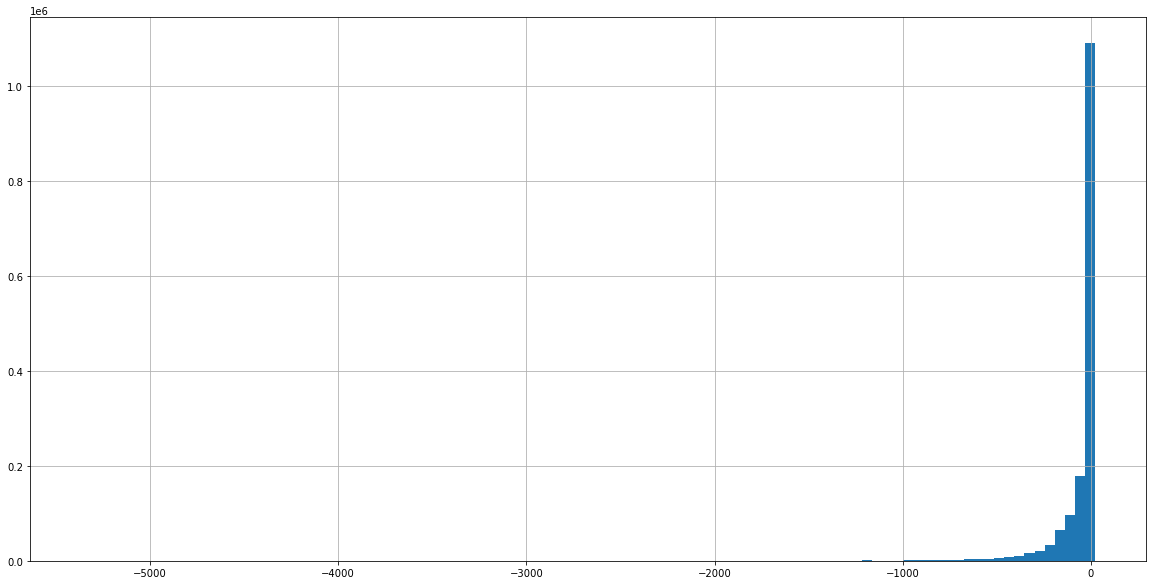

In [81]:
#Histogram of hours between hospital admit and ICU admit
#Some signficant outliers here
raw.HospAdmTime.hist(bins=100)
plt.show()

In [82]:
raw.HospAdmTime.value_counts().sort_index().head(20)

#Some extreme outliers here that don't make sense! 5,366 hours between hospital admit and ICU admit? 
#That is more than 1/2 of a year. Not sure what to do with this at this point...

-5366.86    260
-3710.66     56
-3397.64     36
-3342.34     41
-3322.90     43
-3269.10     21
-3212.56     53
-3189.39     32
-3141.55    275
-3112.12     12
-2929.37     44
-2842.11     12
-2668.77     13
-2667.34     21
-2562.53     22
-2506.69     37
-2476.58     16
-2384.78     29
-2382.34     36
-2379.76     17
Name: HospAdmTime, dtype: int64

In [83]:
#Explore missing demographic values
raw.loc[:,'Age':'SepsisLabel'].isnull().sum().sort_values()

Age                 0
Gender              0
ICULOS              0
SepsisLabel         0
HospAdmTime         8
Unit1          611960
Unit2          611960
dtype: int64

In [84]:
#What's going on with Unit 1 & 2?
raw[['Unit1','Unit2','HospitalA']].value_counts()

Unit1  Unit2  HospitalA
0.0    1.0    0            274193
1.0    0.0    0            262007
              1            204894
0.0    1.0    1            199156
dtype: int64

In [85]:
#Fill nans in Unit1 & Unit2 Columns with 0's
raw[['Unit1','Unit2']]=raw[['Unit1','Unit2']].fillna(value=0)

In [86]:
#Explore missing demographic values
raw.loc[:,'Age':'SepsisLabel'].isnull().sum().sort_values()

Age            0
Gender         0
Unit1          0
Unit2          0
ICULOS         0
SepsisLabel    0
HospAdmTime    8
dtype: int64

### 4.d Distributions - Modified <a class="anchor" id="4.d.Distributions-Modified"></a>

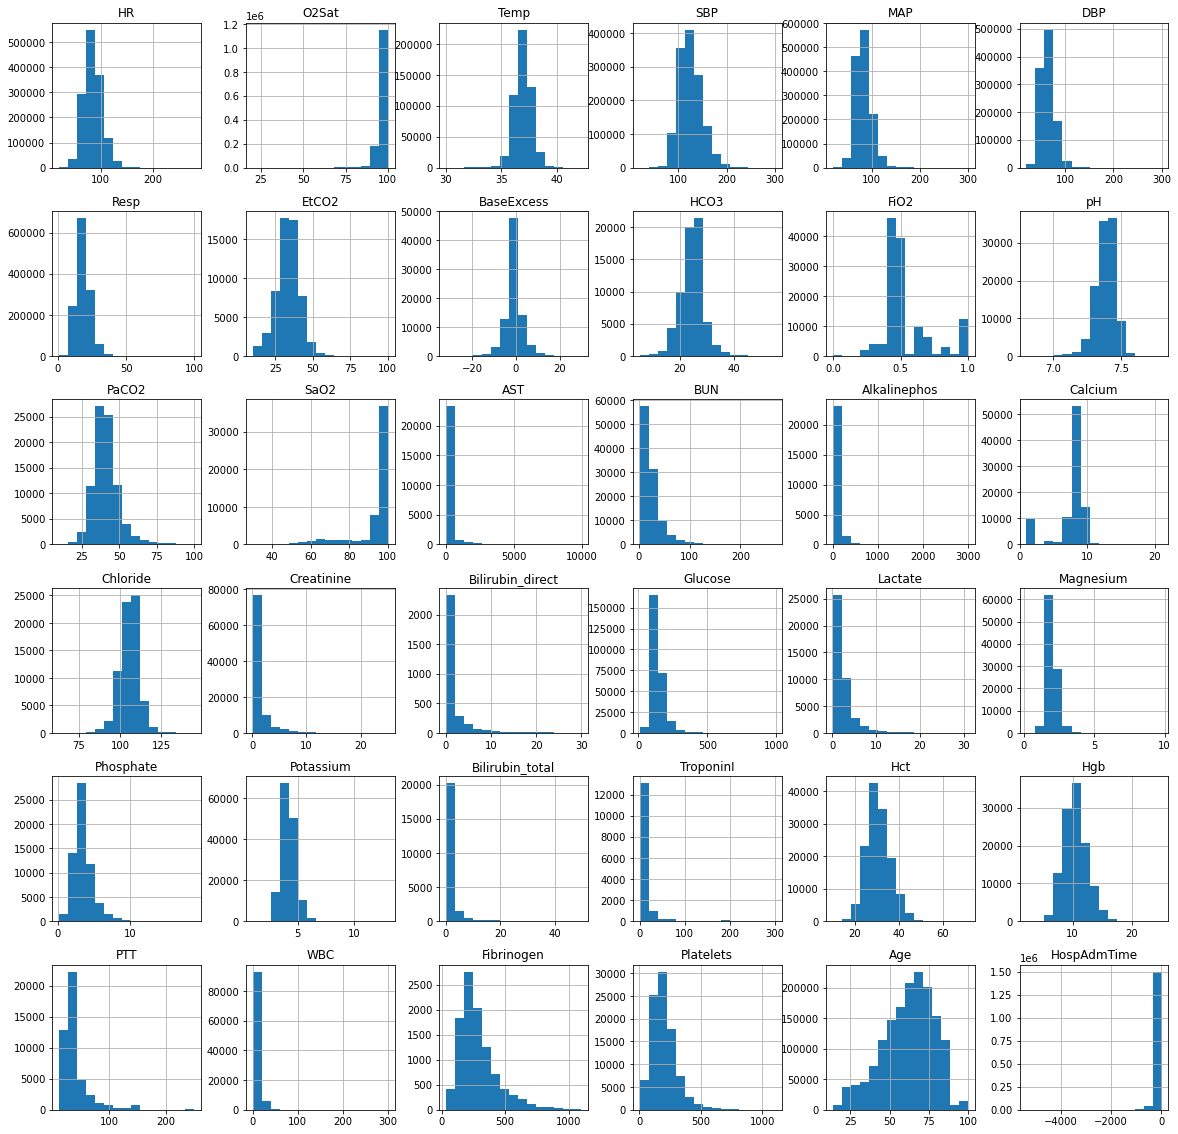

In [87]:
#Plot distributions for numerical features again, with some outliers removed.
raw.drop(labels=['Unit1','Unit2','Gender','SepsisLabel','id','HospitalA','ICULOS'],axis=1).hist(figsize=(20,20),bins=15)
plt.show()

## 5. Data Export<a class="anchor" id="5.DataExport"></a>

In [ ]:
#Save the data 
os.chdir('../interim')
pd.DataFrame.to_csv(raw,'sepsis_data_cleaned.csv')